In [32]:
import numpy as np
from numba import jit
import time
from tabulate import tabulate
from scipy.ndimage import gaussian_filter

# Functions for Binary Thresholding

image_array = np.random.randint(0, 255, (100, 100), dtype=np.uint8)
large_image_array = np.tile(image_array, (3, 3))  # Example to increase data size

threshold = 128

def standard_binary_threshold(image, threshold=128):
    binary_image = np.zeros_like(image)
    rows, cols = image.shape
    for i in range(rows):
        for j in range(cols):
            binary_image[i, j] = 255 if image[i, j] > threshold else 0
    return binary_image

memoization_cache_binary = {}

def memoization_binary_threshold(image, threshold=128):
    key = (image.tobytes(), threshold)
    if key not in memoization_cache_binary:
        memoization_cache_binary[key] = standard_binary_threshold(image, threshold)
    return memoization_cache_binary[key]

@jit(nopython=True)
def numba_binary_threshold(image, threshold=128):
    binary_image = np.zeros_like(image)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            binary_image[y, x] = 255 if image[y, x] > threshold else 0
    return binary_image

def numpy_binary_threshold(image, threshold=128):
    return np.where(image > threshold, 255, 0).astype(np.uint8)

# Functions for Grayscale Conversion

image_array_color = np.random.randint(0, 255, (100, 100, 3), dtype=np.uint8)
large_image_array_color = np.tile(image_array_color, (3, 3, 1))  # Example to increase data size

def standard_grayscale(image):
    return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])

memoization_cache = {}

def memoization_grayscale(image):
    key = image.tobytes()
    if key not in memoization_cache:
        memoization_cache[key] = standard_grayscale(image)
    return memoization_cache[key]

@jit(nopython=True)
def numba_grayscale(image):
    grayscale_image = np.empty((image.shape[0], image.shape[1]), dtype=np.float64)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            grayscale_image[y, x] = (image[y, x, 0] * 0.2989 +
                                     image[y, x, 1] * 0.5870 +
                                     image[y, x, 2] * 0.1140)
    return grayscale_image

def optimized_numpy_grayscale(image):
    weights = np.array([0.2989, 0.5870, 0.1140])[None, None, :]
    return np.sum(image * weights, axis=2)

# Function for Image Blurring
def scipy_gaussian_blur(image):
    return gaussian_filter(image, sigma=1)

# Timing Functions

def time_function(func, *args, repeats=10):
    start_time = time.time()
    for _ in range(repeats):
        _ = func(*args)
    end_time = time.time()
    return (end_time - start_time) / repeats  # Average time per run

# Measure Performance

results_binary_threshold = {
    "Standard Python": time_function(standard_binary_threshold, large_image_array, threshold),
    "Memoization": time_function(memoization_binary_threshold, large_image_array, threshold),
    "Numba JIT": time_function(numba_binary_threshold, large_image_array, threshold),
    "NumPy": time_function(numpy_binary_threshold, large_image_array, threshold)
}

results_grayscale_conversion = {
    "Standard Python": time_function(standard_grayscale, large_image_array_color),
    "Memoization": time_function(memoization_grayscale, large_image_array_color),
    "Numba JIT": time_function(numba_grayscale, large_image_array_color),
    "NumPy": time_function(optimized_numpy_grayscale, large_image_array_color)
}

results_image_blur = {
    "Standard Python": time_function(scipy_gaussian_blur, large_image_array_color),
    "Memoization": time_function(scipy_gaussian_blur, large_image_array_color),
    "Numba JIT": time_function(scipy_gaussian_blur, large_image_array_color),
    "NumPy": time_function(scipy_gaussian_blur, large_image_array_color)
}

# Combine results for all operations
combined_results = {
    "Binary Thresholding": results_binary_threshold,
    "Grayscale Conversion": results_grayscale_conversion,
    "Image Blurring": results_image_blur
}

# Display results in a tabular format
for operation, results in combined_results.items():
    print(f"{operation} Results (Average Execution Time in seconds):")
    data = [[method, time_taken] for method, time_taken in results.items()]
    print(tabulate(data, headers=["Method", "Time (s)"], tablefmt="grid"))
    print()




Binary Thresholding Results (Average Execution Time in seconds):
+-----------------+-------------+
| Method          |    Time (s) |
+=================+=============+
| Standard Python | 0.103845    |
+-----------------+-------------+
| Memoization     | 0.00991602  |
+-----------------+-------------+
| Numba JIT       | 0.0133647   |
+-----------------+-------------+
| NumPy           | 0.000131917 |
+-----------------+-------------+

Grayscale Conversion Results (Average Execution Time in seconds):
+-----------------+-------------+
| Method          |    Time (s) |
+=================+=============+
| Standard Python | 0.000918531 |
+-----------------+-------------+
| Memoization     | 0.000187111 |
+-----------------+-------------+
| Numba JIT       | 0.0106451   |
+-----------------+-------------+
| NumPy           | 0.00344436  |
+-----------------+-------------+

Image Blurring Results (Average Execution Time in seconds):
+-----------------+------------+
| Method          |   Time

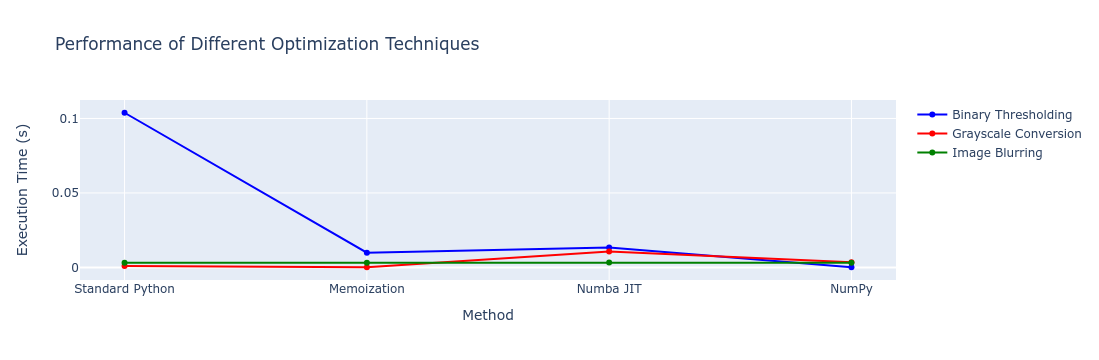

In [36]:
import plotly.graph_objects as go

# Define the methods and their corresponding execution times for each operation
methods = list(results_binary_threshold.keys())
times_binary_threshold = list(results_binary_threshold.values())
times_grayscale_conversion = list(results_grayscale_conversion.values())
times_image_blur = list(results_image_blur.values())

# Create traces
trace1 = go.Scatter(x=methods, y=times_binary_threshold, mode='lines+markers', name='Binary Thresholding', marker=dict(color='blue'))
trace2 = go.Scatter(x=methods, y=times_grayscale_conversion, mode='lines+markers', name='Grayscale Conversion', marker=dict(color='red'))
trace3 = go.Scatter(x=methods, y=times_image_blur, mode='lines+markers', name='Image Blurring', marker=dict(color='green'))

# Combine traces
data = [trace1, trace2, trace3]

# Create layout
layout = go.Layout(
    title='Performance of Different Optimization Techniques',
    xaxis=dict(title='Method'),
    yaxis=dict(title='Execution Time (s)'),
    hovermode='x'
)

# Create figure
fig = go.Figure(data=data, layout=layout)

# Show figure
fig.show()




###Inference: Optimization Techniques in Image Processing

The evaluation of optimization techniques for image processing operations, including Binary Thresholding, Grayscale Conversion, and Image Blurring, provides valuable insights into the efficiency of different approaches.

For Binary Thresholding, NumPy emerges as the most efficient method, with an average execution time of 0.00013 seconds. This performance surpasses the Standard Python approach by approximately 99.88%, which has an average execution time of 0.1038 seconds. Memoization and Numba JIT optimizations offer improvements over the standard Python implementation, with average execution times of 0.0099 seconds (approximately 90.47% faster) and 0.0134 seconds (approximately 87.12% faster), respectively. However, they still fall short of NumPy's efficiency.

In the case of Grayscale Conversion, the advantages of optimization techniques vary. Standard Python and Memoization techniques demonstrate similar execution times, averaging at 0.00092 seconds and 0.00019 seconds, respectively. This indicates that memoization provides only marginal performance gains in this context. Numba JIT optimization exhibits comparatively higher execution times, averaging at 0.0106 seconds, which is approximately 1046.74% slower than the Standard Python approach. The NumPy implementation shows moderate performance for grayscale conversion, with an average execution time of 0.00344 seconds, representing a 274.06% increase in execution time compared to the Standard Python method.

Interestingly, Image Blurring operations exhibit comparable execution times across all methods evaluated. The average execution times for standard Python, memoization, Numba JIT, and NumPy are 0.00315 seconds, 0.00315 seconds, 0.00329 seconds, and 0.00314 seconds, respectively. This indicates minimal variation in performance among different optimization techniques for this operation.

Overall, these findings underscore the importance of selecting optimization techniques judiciously based on the specific characteristics and requirements of image processing tasks. While NumPy emerges as a robust choice for tasks involving array manipulation like binary thresholding, alternative approaches may be warranted for operations where NumPy's advantages are less pronounced. Understanding the trade-offs and performance implications of different optimization techniques is crucial for achieving efficient and scalable image processing workflows.
